# cox univariant

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from lifelines import KaplanMeierFitter
#from ydata_profiling import ProfileReport
import pickle
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter, statistics
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold


#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
#from sklearn.ensemble import RandomForestRegressor




%load_ext autoreload
%autoreload 2

from configs import IMMUNE_PROTEINS, PROCESSED_PROTEOMICS_DATA, KERATIN, MIN_FEATURES,CLINICAL_DATA,COX_LIST
from utils import load_raw_proteomics_data, rename_columns, drop_protein, describe_proteins_and_samples, norm_and_log,prepare_data_to_model,describe_clinical_data

#from survival_analysis_utils import cox_proportional_hazard_model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## data with nan values


In [53]:
final_df = pd.read_csv("/home/labs/hornsteinlab/Collaboration/PRIMALS/Serum/Hadar/data_prossesing_final.csv").set_index('sample number')
final_df = prepare_data_to_model(final_df)
final_df

Loading clinical data from /home/labs/hornsteinlab/Collaboration/PRIMALS/Serum/Hadar/clinical_data_hadar.csv
Shape: (179, 19)


,IGKV3-7,IGLV4-69,IGLV8-61,IGLV10-54,IGLV7-46,IGLV2-18,IGLV3-12,IGLV3-10,IGLV3-9,IGHV3-64,...,COLEC10,APOA2_1,C1QA_1,Survival_from_onset (months),Status dead=1,Sex,Disease Format,ALSFRS score (unit),ALSFRS_group,Age Onset (years)
sample number,,,,,,,,,,,,,,,,,,,,,
705,-10.204612,-10.677011,-10.371133,NaN,-10.386636,-10.708409,-10.775475,-10.387228,-10.398862,-10.477047,...,-10.367277,-10.838142,-10.920926,40,1,0,0,41,4,73
712,-10.261845,-10.631851,-10.553399,-11.033184,-10.423710,-10.553404,-10.781720,-10.423317,-10.412205,-10.730202,...,-10.393928,-10.631400,-10.930997,55,1,0,0,43,5,63
717,-10.181705,-10.596433,-10.329450,-10.801589,-10.347386,-10.586745,-10.618414,-10.385198,-10.328863,-10.465309,...,-10.361038,-10.591157,-10.895410,5,1,0,0,37,4,70
735,-10.201382,-10.620339,-10.525987,-10.974413,-10.394055,-10.628799,-10.773907,-10.424033,-10.409433,-10.614421,...,-10.370060,-10.699101,-10.765072,9,1,0,0,34,4,65
746,-10.315008,-10.890091,-10.478634,NaN,-10.518827,-10.726851,NaN,-10.535779,-10.430381,-10.614006,...,-10.373641,-10.813603,-10.790747,5,1,0,1,44,5,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,-10.213779,-10.589771,NaN,-10.901073,-10.311487,-10.580031,-10.571975,-10.385638,-10.289457,-10.474354,...,-10.316921,NaN,-10.476288,80,0,0,0,39,4,64
1900,-10.154755,-10.651093,-10.311946,NaN,-10.368999,-10.833229,NaN,-10.562737,-10.423335,-10.521348,...,-10.324470,-10.680722,-10.440002,26,1,1,1,45,5,78
1912,-10.114605,-10.549059,-10.556772,-10.874781,-10.491286,-10.666894,-10.672145,-10.367900,-10.379130,-10.468953,...,-10.378270,-10.632625,-10.624632,48,0,0,0,40,4,55


## data fill nan


In [54]:
final_df_fill_nan = pd.read_csv("/home/labs/hornsteinlab/Collaboration/PRIMALS/Serum/Hadar/data_fill_nan.csv")
# final_df_fill_nan = load_and_merge_with_clinical(final_df_fill_nan)
final_df_fill_nan = final_df_fill_nan.rename(columns={'Unnamed: 0': 'sample number'}).set_index("sample number")
final_df_fill_nan

,unidentified,unidentified_1,unidentified_2,unidentified_3,SERPINA1,IGKV3-7,IGLV4-69,IGLV8-61,IGLV4-60,IGLV10-54,...,SAR1B,EMILIN1,MTCH2,BZW2,DYNC1LI1,SQOR,ROBO1,AP1M2,FCGBP,PCLO
sample number,,,,,,,,,,,,,,,,,,,,,
705,-31.303171,-10.383076,-10.855475,-10.549598,-31.303171,-31.303171,-31.303171,-10.565100,-31.303171,-10.886874,...,-31.303171,-31.303171,-10.923774,-31.303171,-10.426534,-10.528589,-31.303171,-10.545741,-11.016606,-11.099391
712,-10.708563,-10.490791,-10.860798,-10.782345,-31.362377,-11.262131,-31.362377,-10.652656,-10.960329,-10.782350,...,-31.362377,-31.362377,-31.362377,-31.362377,-10.496391,-10.610470,-11.346486,-10.622874,-10.860346,-11.159943
717,-10.578274,-10.353125,-10.767853,-10.500871,-31.285681,-10.973009,-10.953699,-10.518806,-10.848228,-10.758165,...,-31.285681,-31.285681,-10.914522,-31.285681,-10.388225,-10.470334,-11.217580,-10.532459,-10.762577,-11.066830
735,-10.657849,-10.386119,-10.805077,-10.710725,-31.306051,-11.159150,-11.037519,-10.578793,-31.306051,-10.813537,...,-31.306051,-31.306051,-10.889386,-31.306051,-10.419124,-10.572859,-11.242285,-10.554798,-10.883839,-10.949809
746,-31.383629,-10.600636,-11.175719,-10.764262,-31.383629,-31.383629,-31.383629,-10.804454,-31.383629,-11.012478,...,-31.383629,-31.383629,-31.383629,-31.383629,-10.541618,-10.733691,-31.383629,-10.659268,-11.099230,-11.076374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,-10.446134,-10.368998,-10.744989,-31.244110,-31.244110,-11.056292,-31.244110,-10.466705,-31.244110,-10.735249,...,-31.244110,-11.191128,-10.742927,-31.244110,-10.339610,-10.557948,-31.244110,-10.472140,-31.244110,-10.631507
1900,-31.237343,-10.298485,-10.794822,-10.455676,-31.237343,-31.237343,-31.237343,-10.512729,-31.237343,-10.976959,...,-31.237343,-31.237343,-31.237343,-31.237343,-10.363594,-10.525813,-31.237343,-10.468200,-10.824452,-10.583732
1912,-10.473279,-10.278782,-10.713236,-10.720949,-31.290314,-11.038958,-31.290314,-10.655463,-31.290314,-10.831071,...,-31.290314,-31.290314,-10.922729,-31.290314,-10.379494,-10.519648,-31.290314,-10.542447,-10.796802,-10.788809


## merge protein with clinical data

In [55]:
#merge will clinical data
data = prepare_data_to_model(final_df_fill_nan)
data

Loading clinical data from /home/labs/hornsteinlab/Collaboration/PRIMALS/Serum/Hadar/clinical_data_hadar.csv
Shape: (179, 19)


,unidentified,unidentified_1,unidentified_2,unidentified_3,SERPINA1,IGKV3-7,IGLV4-69,IGLV8-61,IGLV4-60,IGLV10-54,...,AP1M2,FCGBP,PCLO,Survival_from_onset (months),Status dead=1,Sex,Disease Format,ALSFRS score (unit),ALSFRS_group,Age Onset (years)
sample number,,,,,,,,,,,,,,,,,,,,,
705,-31.303171,-10.383076,-10.855475,-10.549598,-31.303171,-31.303171,-31.303171,-10.565100,-31.303171,-10.886874,...,-10.545741,-11.016606,-11.099391,40,1,0,0,41,4,73
712,-10.708563,-10.490791,-10.860798,-10.782345,-31.362377,-11.262131,-31.362377,-10.652656,-10.960329,-10.782350,...,-10.622874,-10.860346,-11.159943,55,1,0,0,43,5,63
717,-10.578274,-10.353125,-10.767853,-10.500871,-31.285681,-10.973009,-10.953699,-10.518806,-10.848228,-10.758165,...,-10.532459,-10.762577,-11.066830,5,1,0,0,37,4,70
735,-10.657849,-10.386119,-10.805077,-10.710725,-31.306051,-11.159150,-11.037519,-10.578793,-31.306051,-10.813537,...,-10.554798,-10.883839,-10.949809,9,1,0,0,34,4,65
746,-31.383629,-10.600636,-11.175719,-10.764262,-31.383629,-31.383629,-31.383629,-10.804454,-31.383629,-11.012478,...,-10.659268,-11.099230,-11.076374,5,1,0,1,44,5,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,-10.446134,-10.368998,-10.744989,-31.244110,-31.244110,-11.056292,-31.244110,-10.466705,-31.244110,-10.735249,...,-10.472140,-31.244110,-10.631507,80,0,0,0,39,4,64
1900,-31.237343,-10.298485,-10.794822,-10.455676,-31.237343,-31.237343,-31.237343,-10.512729,-31.237343,-10.976959,...,-10.468200,-10.824452,-10.583732,26,1,1,1,45,5,78
1912,-10.473279,-10.278782,-10.713236,-10.720949,-31.290314,-11.038958,-31.290314,-10.655463,-31.290314,-10.831071,...,-10.542447,-10.796802,-10.788809,48,0,0,0,40,4,55


In [2]:
pd.read_csv("clinical_data_hadar.csv") 

,sample number,ID,Birth year,Age Onset (years),Sex,12 Education years,Former athlete,Disease Format,diagn delay (months),Survival_from_onset (months),Status dead=1,ALSFRS score (unit),deltaFRS (-unit/months),Age at Collection (years),ALSFRS_group,deltaFRS_groups,DD_by_cat,Age_onset_cat,Survival_onset_cat
0,705,J30K59,1936,73,M,Below,No,Limb,12,40,1,41,0.583333,74,4,2.0,2,1,2
1,712,S20S79,1946,63,M,NaN,No,Limb,12,55,1,43,0.416667,64,5,3.0,2,2,3
2,717,L75U65,1939,70,M,Above,No,Limb,3,5,1,37,3.666667,71,4,1.0,1,2,1
3,735,B02E34,1944,65,M,Above,No,Limb,4,9,1,34,3.500000,66,4,1.0,1,2,1
4,746,F74V70,1972,37,M,Above,No,Bulbar,2,5,1,44,1.000000,38,5,2.0,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,1899,K01A78,1951,64,M,Below,No,Limb,41,80,0,39,0.214286,68,4,3.0,3,2,3
175,1900,B46B28,1941,78,F,Below,No,Bulbar,6,26,1,45,0.500000,78,5,3.0,1,1,1
176,1912,A90A55,1963,55,M,Below,No,Limb,1,48,0,40,1.600000,56,4,1.0,1,4,2
177,1913,H65G96,1948,70,F,Above,No,Limb,12,37,1,42,0.500000,71,4,3.0,2,2,2


### cox univariant - drop nan values - my code

In [16]:
####provide me 19 sig results


data = final_df
cox_p = {}
concordance_index = {}
hazard_ratios = {}


protein_names = [col for col in data.columns if col not in ['Status dead=1',  'Survival_from_onset (months)']]
for protein_name in protein_names:
    
    cox_data = data.dropna(subset=[protein_name])
    cph = cox_proportional_hazard_model(cox_data[[protein_name, 'Status dead=1',  'Survival_from_onset (months)']],
                                        'Survival_from_onset (months)',
                                        'Status dead=1',
                                        protein_name,
                                        strata=None,
                                        covariate_groups=None,
                                        show_plot=False)
    
    p_value = cph.summary.loc[protein_name]['p']
    c_index = cph.concordance_index_
    hazard_ratio = cph.hazard_ratios_[protein_name]

    cox_p[protein_name] = p_value
    concordance_index[protein_name] = c_index
    hazard_ratios[protein_name] = hazard_ratio

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'p_value': pd.Series(cox_p),
    'concordance_index': pd.Series(concordance_index),
    'hazard_ratio': pd.Series(hazard_ratios)
})

# Display the DataFrame
results_df






 Concordance index of the model 0.5409569053274517


 Concordance index of the model 0.4813299613210354


 Concordance index of the model 0.5330584597261081


 Concordance index of the model 0.5520129694677114


 Concordance index of the model 0.5419070240922973


 Concordance index of the model 0.5399823193763562


 Concordance index of the model 0.4841332804442681


 Concordance index of the model 0.5465897522904649


 Concordance index of the model 0.5212758737699356


 Concordance index of the model 0.5430277244029645


 Concordance index of the model 0.5028852920478536


 Concordance index of the model 0.49582985821517933


 Concordance index of the model 0.5334049409237379


 Concordance index of the model 0.5289446895147608


 Concordance index of the model 0.5031699858282986


 Concordance index of the model 0.4950118764845606


 Concordance index of the model 0.5041584158415842


 Concordance index of the model 0.5186969799796403


 Concordance index of the model 0.516185951

,p_value,concordance_index,hazard_ratio
IGKV3-7,0.474659,0.540957,0.575217
IGLV4-69,0.743204,0.481330,1.192438
IGLV8-61,0.652880,0.533058,0.759436
IGLV10-54,0.514602,0.552013,0.578473
IGLV7-46,0.531690,0.541907,0.644354
...,...,...,...
Sex,0.862140,0.498575,1.023128
Disease Format,0.370826,0.524499,1.144909
ALSFRS score (unit),0.125358,0.557686,0.985859
ALSFRS_group,0.175887,0.551340,0.910423


In [19]:
# Filter significant proteins
significant_proteins_df = results_df[results_df['p_value'] < 0.05]
significant_proteins_df

,p_value,concordance_index,hazard_ratio
MYO15B,0.020304,0.588531,8.471759
PDCD6,0.036533,0.576358,3.036478
OXSR1,0.007521,0.619709,12.590128
LMNA,0.042277,0.560484,5.946083
MT1E;MT1G;MT1M;MT1X;MT2A,0.038174,0.558276,4.072726
HSPB1,0.045703,0.555685,4.916228
CALM1;CALM2;CALM3,0.043209,0.577007,5.112464
KIF5B,0.036302,0.567381,4.693272
ALDH9A1,0.044872,0.572615,5.537585
EIF5A,0.019808,0.586928,6.154852


In [18]:
significant_proteins_df.shape

((19, 3),
                            p_value  concordance_index  hazard_ratio
 MYO15B                    0.020304           0.588531      8.471759
 PDCD6                     0.036533           0.576358      3.036478
 OXSR1                     0.007521           0.619709     12.590128
 LMNA                      0.042277           0.560484      5.946083
 MT1E;MT1G;MT1M;MT1X;MT2A  0.038174           0.558276      4.072726
 HSPB1                     0.045703           0.555685      4.916228
 CALM1;CALM2;CALM3         0.043209           0.577007      5.112464
 KIF5B                     0.036302           0.567381      4.693272
 ALDH9A1                   0.044872           0.572615      5.537585
 EIF5A                     0.019808           0.586928      6.154852
 PPP2CA                    0.034604           0.583276     11.938302
 PAFAH1B2                  0.029093           0.597747      8.089205
 EIF4G1                    0.030600           0.558857      6.987985
 GLO1                   

In [23]:
significant_proteins_df = significant_proteins_df.reset_index()
significant_proteins_df

,index,p_value,concordance_index,hazard_ratio
0,MYO15B,0.020304,0.588531,8.471759
1,PDCD6,0.036533,0.576358,3.036478
2,OXSR1,0.007521,0.619709,12.590128
3,LMNA,0.042277,0.560484,5.946083
4,MT1E;MT1G;MT1M;MT1X;MT2A,0.038174,0.558276,4.072726
5,HSPB1,0.045703,0.555685,4.916228
6,CALM1;CALM2;CALM3,0.043209,0.577007,5.112464
7,KIF5B,0.036302,0.567381,4.693272
8,ALDH9A1,0.044872,0.572615,5.537585
9,EIF5A,0.019808,0.586928,6.154852


In [34]:
data

,IGKV3-7,IGLV4-69,IGLV8-61,IGLV10-54,IGLV7-46,IGLV2-18,IGLV3-12,IGLV3-10,IGLV3-9,IGHV3-64,...,COLEC10,APOA2_1,C1QA_1,Survival_from_onset (months),Status dead=1,Sex,Disease Format,ALSFRS score (unit),ALSFRS_group,Age Onset (years)
sample number,,,,,,,,,,,,,,,,,,,,,
705,-10.204612,-10.677011,-10.371133,NaN,-10.386636,-10.708409,-10.775475,-10.387228,-10.398862,-10.477047,...,-10.367277,-10.838142,-10.920926,40,1,0,0,41,4,73
712,-10.261845,-10.631851,-10.553399,-11.033184,-10.423710,-10.553404,-10.781720,-10.423317,-10.412205,-10.730202,...,-10.393928,-10.631400,-10.930997,55,1,0,0,43,5,63
717,-10.181705,-10.596433,-10.329450,-10.801589,-10.347386,-10.586745,-10.618414,-10.385198,-10.328863,-10.465309,...,-10.361038,-10.591157,-10.895410,5,1,0,0,37,4,70
735,-10.201382,-10.620339,-10.525987,-10.974413,-10.394055,-10.628799,-10.773907,-10.424033,-10.409433,-10.614421,...,-10.370060,-10.699101,-10.765072,9,1,0,0,34,4,65
746,-10.315008,-10.890091,-10.478634,NaN,-10.518827,-10.726851,NaN,-10.535779,-10.430381,-10.614006,...,-10.373641,-10.813603,-10.790747,5,1,0,1,44,5,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,-10.213779,-10.589771,NaN,-10.901073,-10.311487,-10.580031,-10.571975,-10.385638,-10.289457,-10.474354,...,-10.316921,NaN,-10.476288,80,0,0,0,39,4,64
1900,-10.154755,-10.651093,-10.311946,NaN,-10.368999,-10.833229,NaN,-10.562737,-10.423335,-10.521348,...,-10.324470,-10.680722,-10.440002,26,1,1,1,45,5,78
1912,-10.114605,-10.549059,-10.556772,-10.874781,-10.491286,-10.666894,-10.672145,-10.367900,-10.379130,-10.468953,...,-10.378270,-10.632625,-10.624632,48,0,0,0,40,4,55


#### km seperation base on median

In [28]:
protein_medians = data.median()
protein_medians

IGKV3-7               -10.197222
IGLV4-69              -10.626069
IGLV8-61              -10.407996
IGLV10-54             -10.901083
IGLV7-46              -10.386636
                         ...    
Sex                     0.000000
Disease Format          0.000000
ALSFRS score (unit)    39.000000
ALSFRS_group            4.000000
Age Onset (years)      61.000000
Length: 1592, dtype: float64

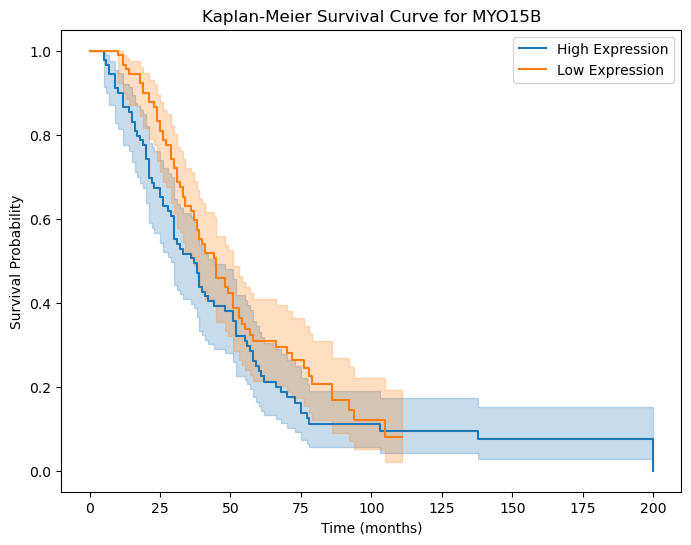

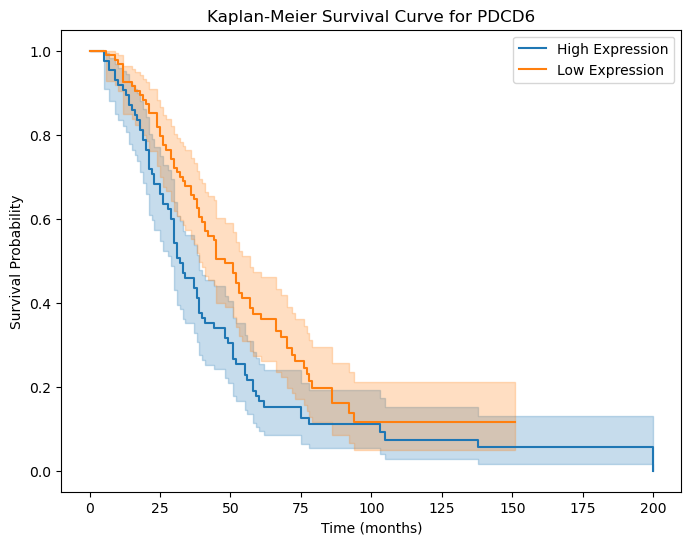

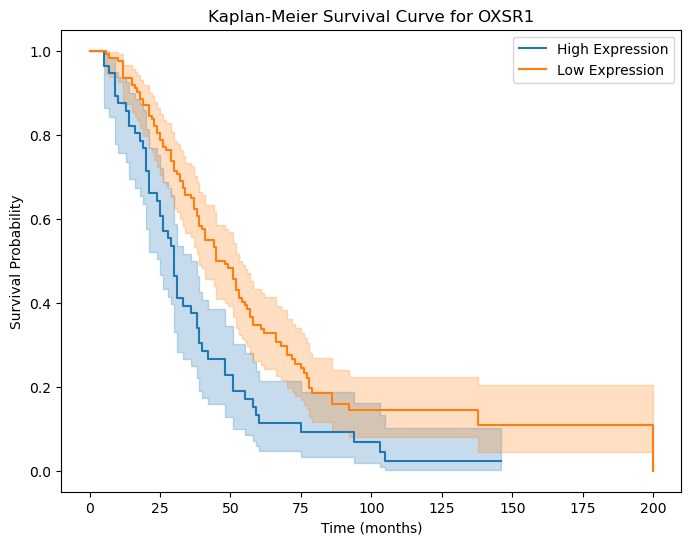

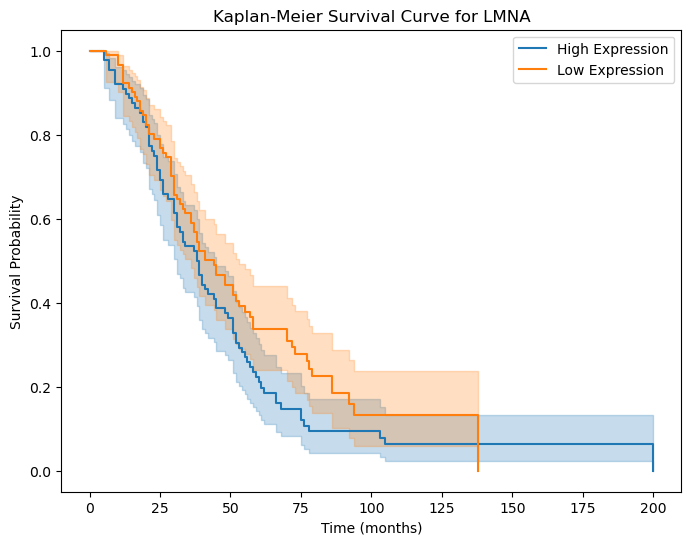

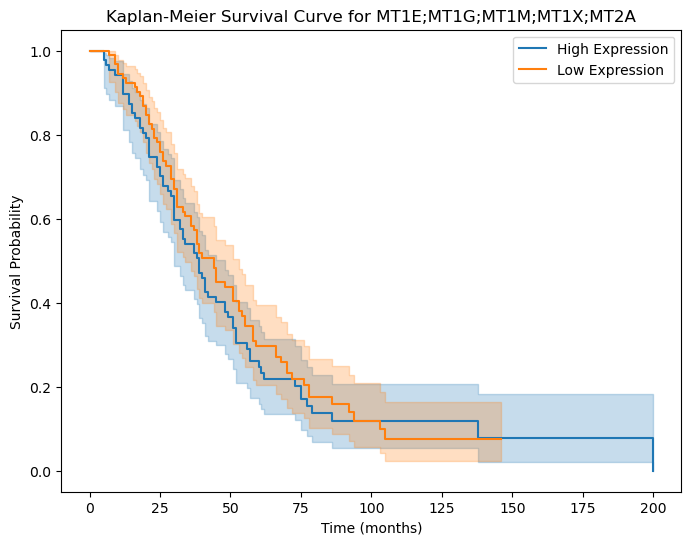

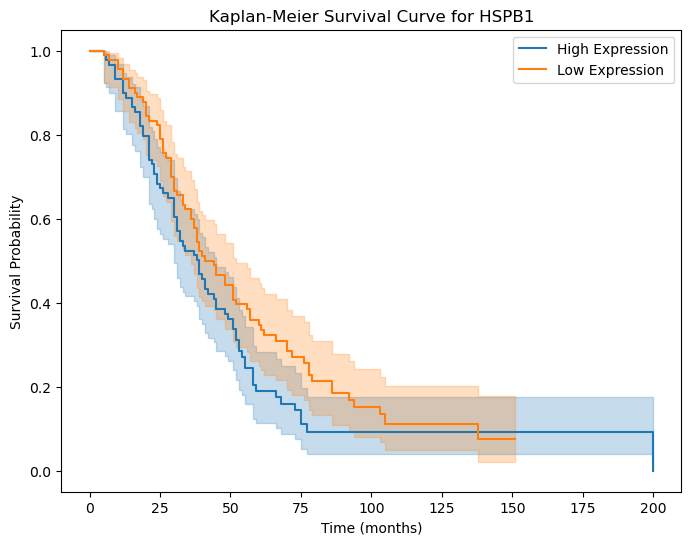

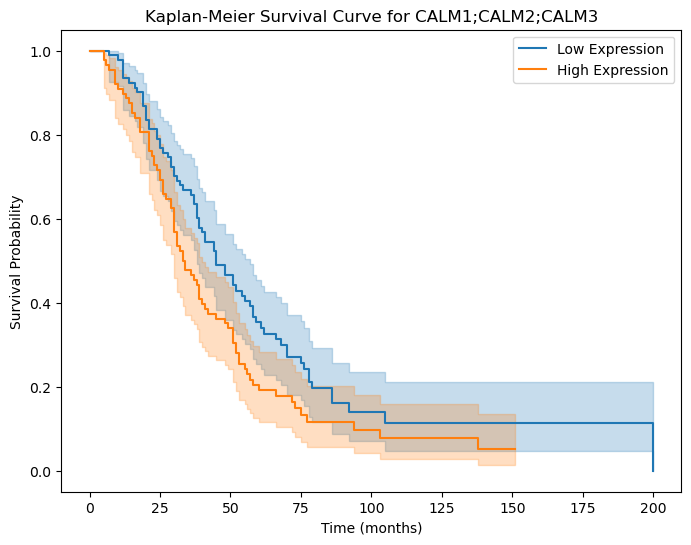

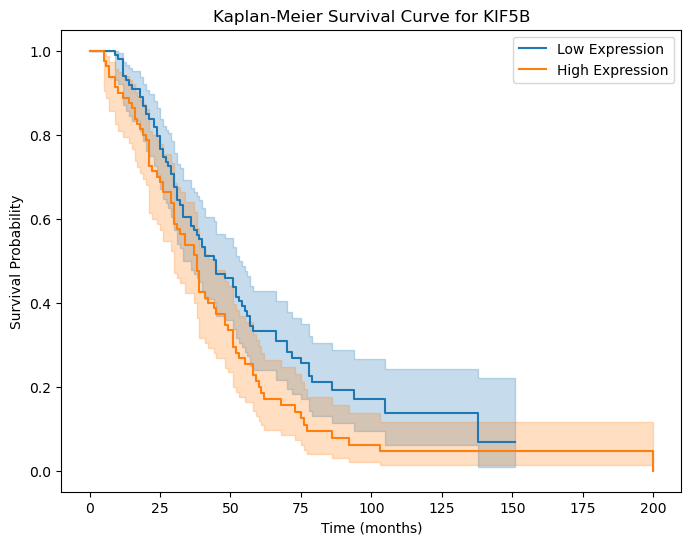

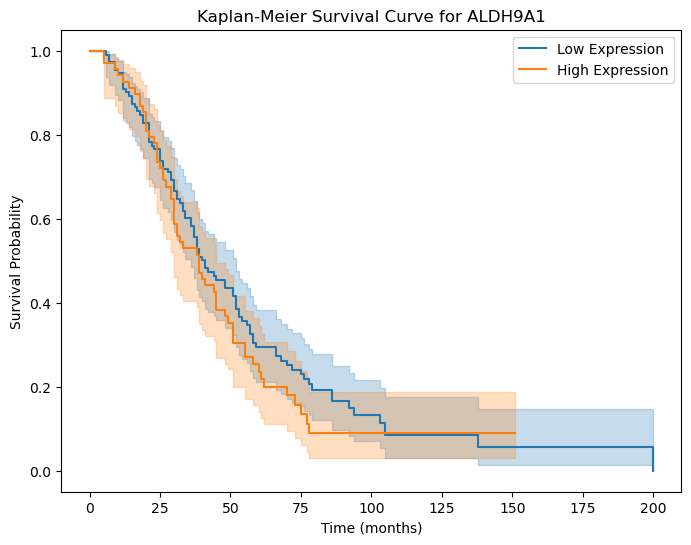

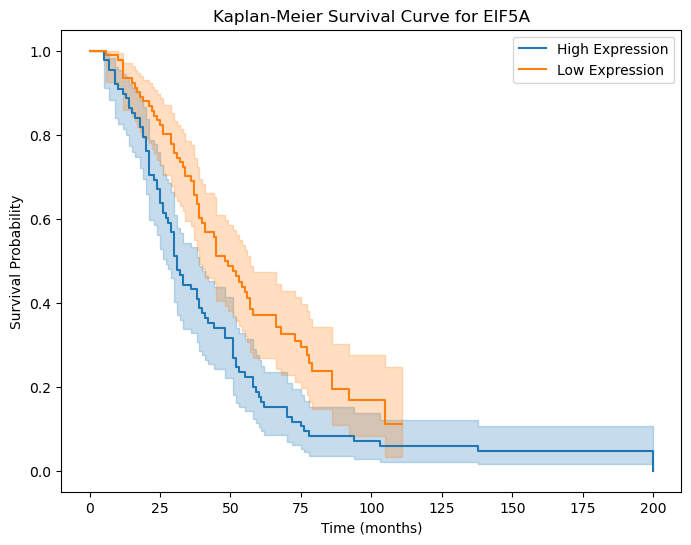

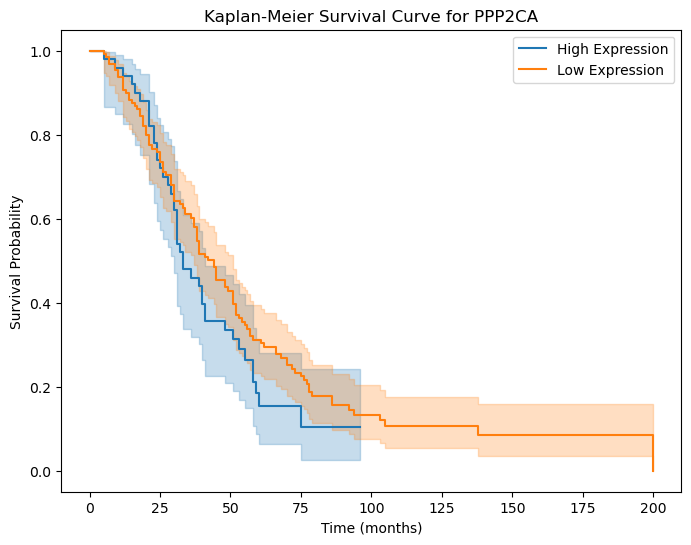

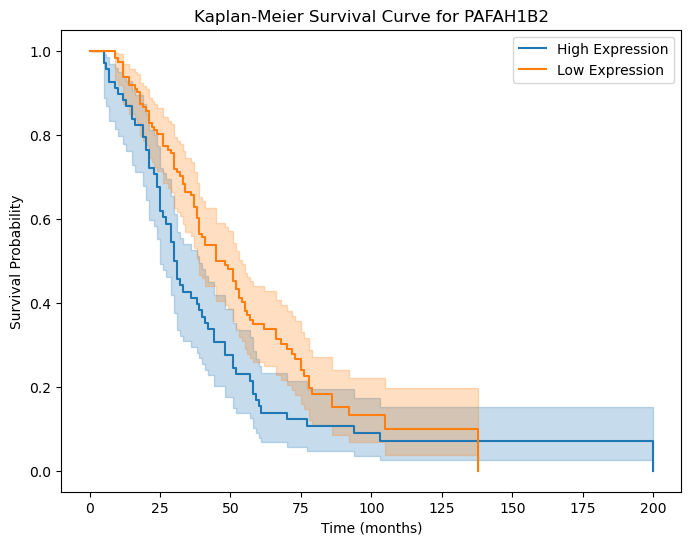

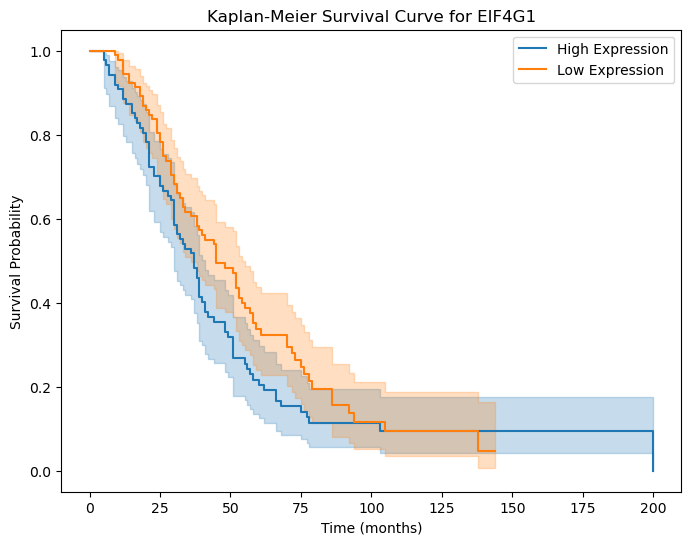

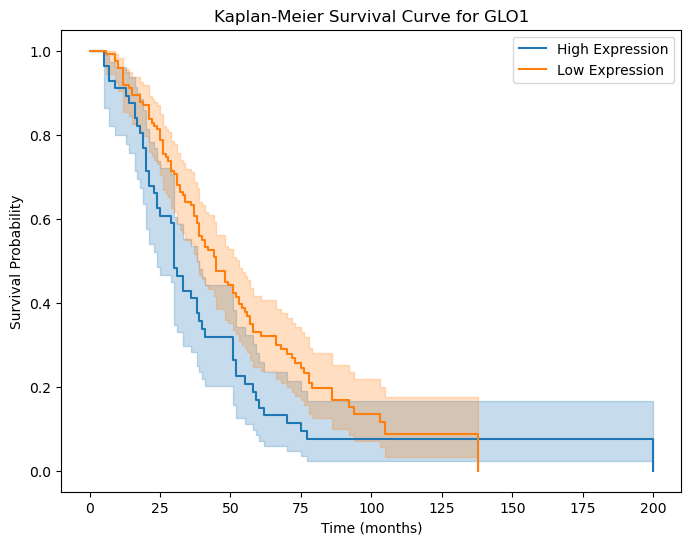

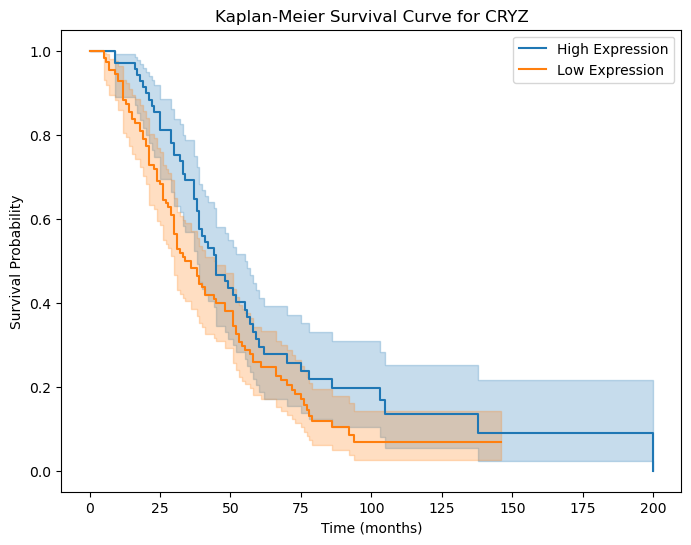

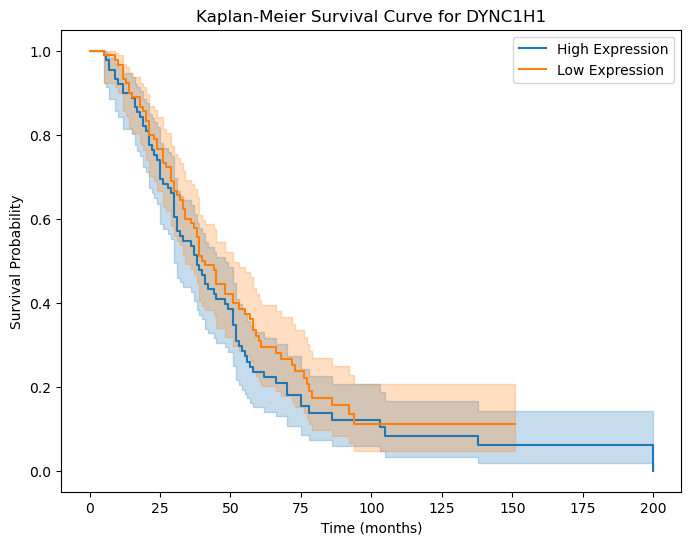

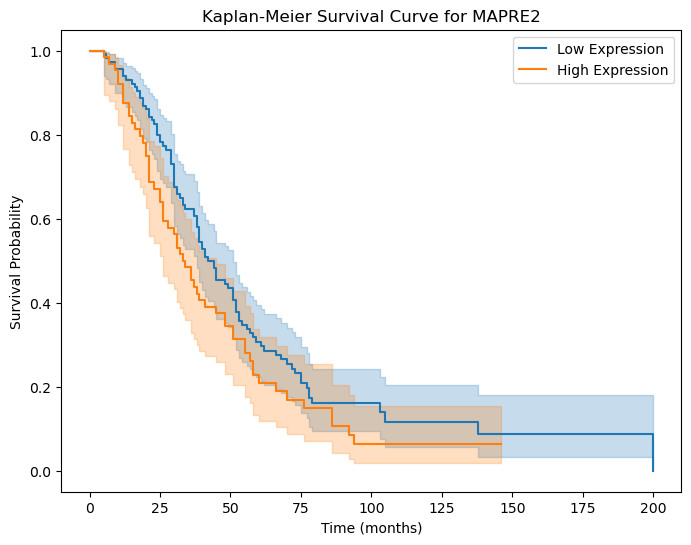

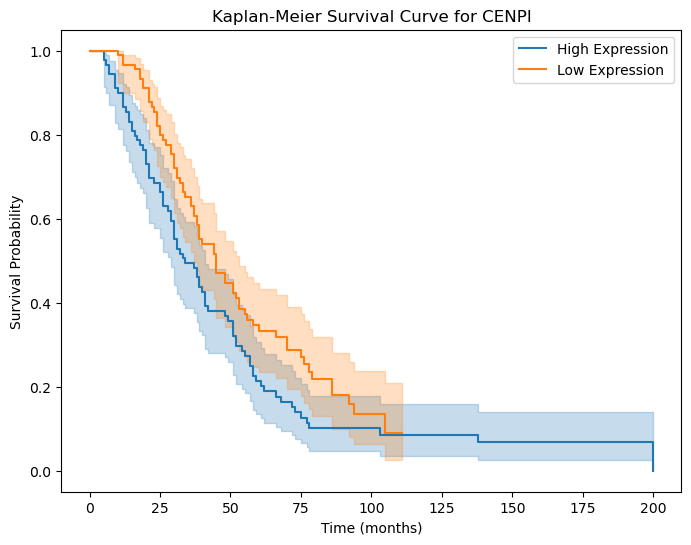

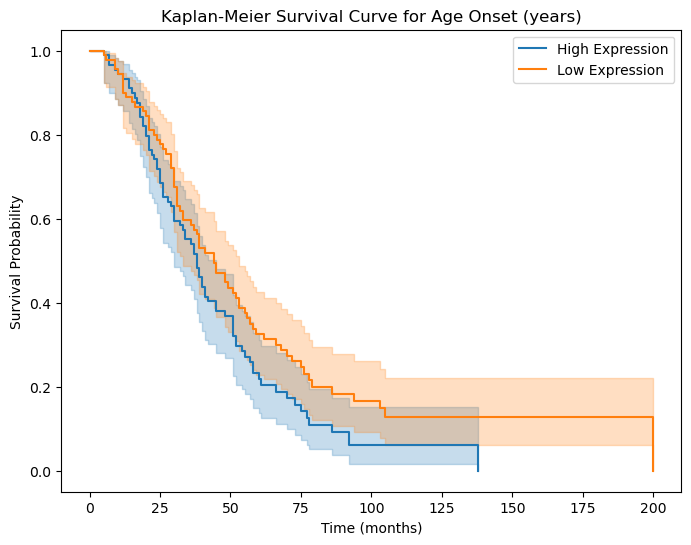

In [40]:
###OLD
kmf = KaplanMeierFitter()

for protein in MIN_FEATURES:
    plt.figure(figsize=(8, 6))
    
    # Create high and low expression groups based on the median expression level
    median_expression = data[protein].median()
    data['expression_group'] = data[protein] > median_expression
    
    for group in data['expression_group'].unique():
        mask = data['expression_group'] == group
        kmf.fit(durations=data['Survival_from_onset (months)'][mask], 
                event_observed=data['Status dead=1'][mask], 
                label=f'High Expression' if group else 'Low Expression')
        kmf.plot_survival_function()

    plt.title(f'Kaplan-Meier Survival Curve for {protein}')
    plt.xlabel('Time (months)')
    plt.ylabel('Survival Probability')
    plt.legend()
    plt.show()

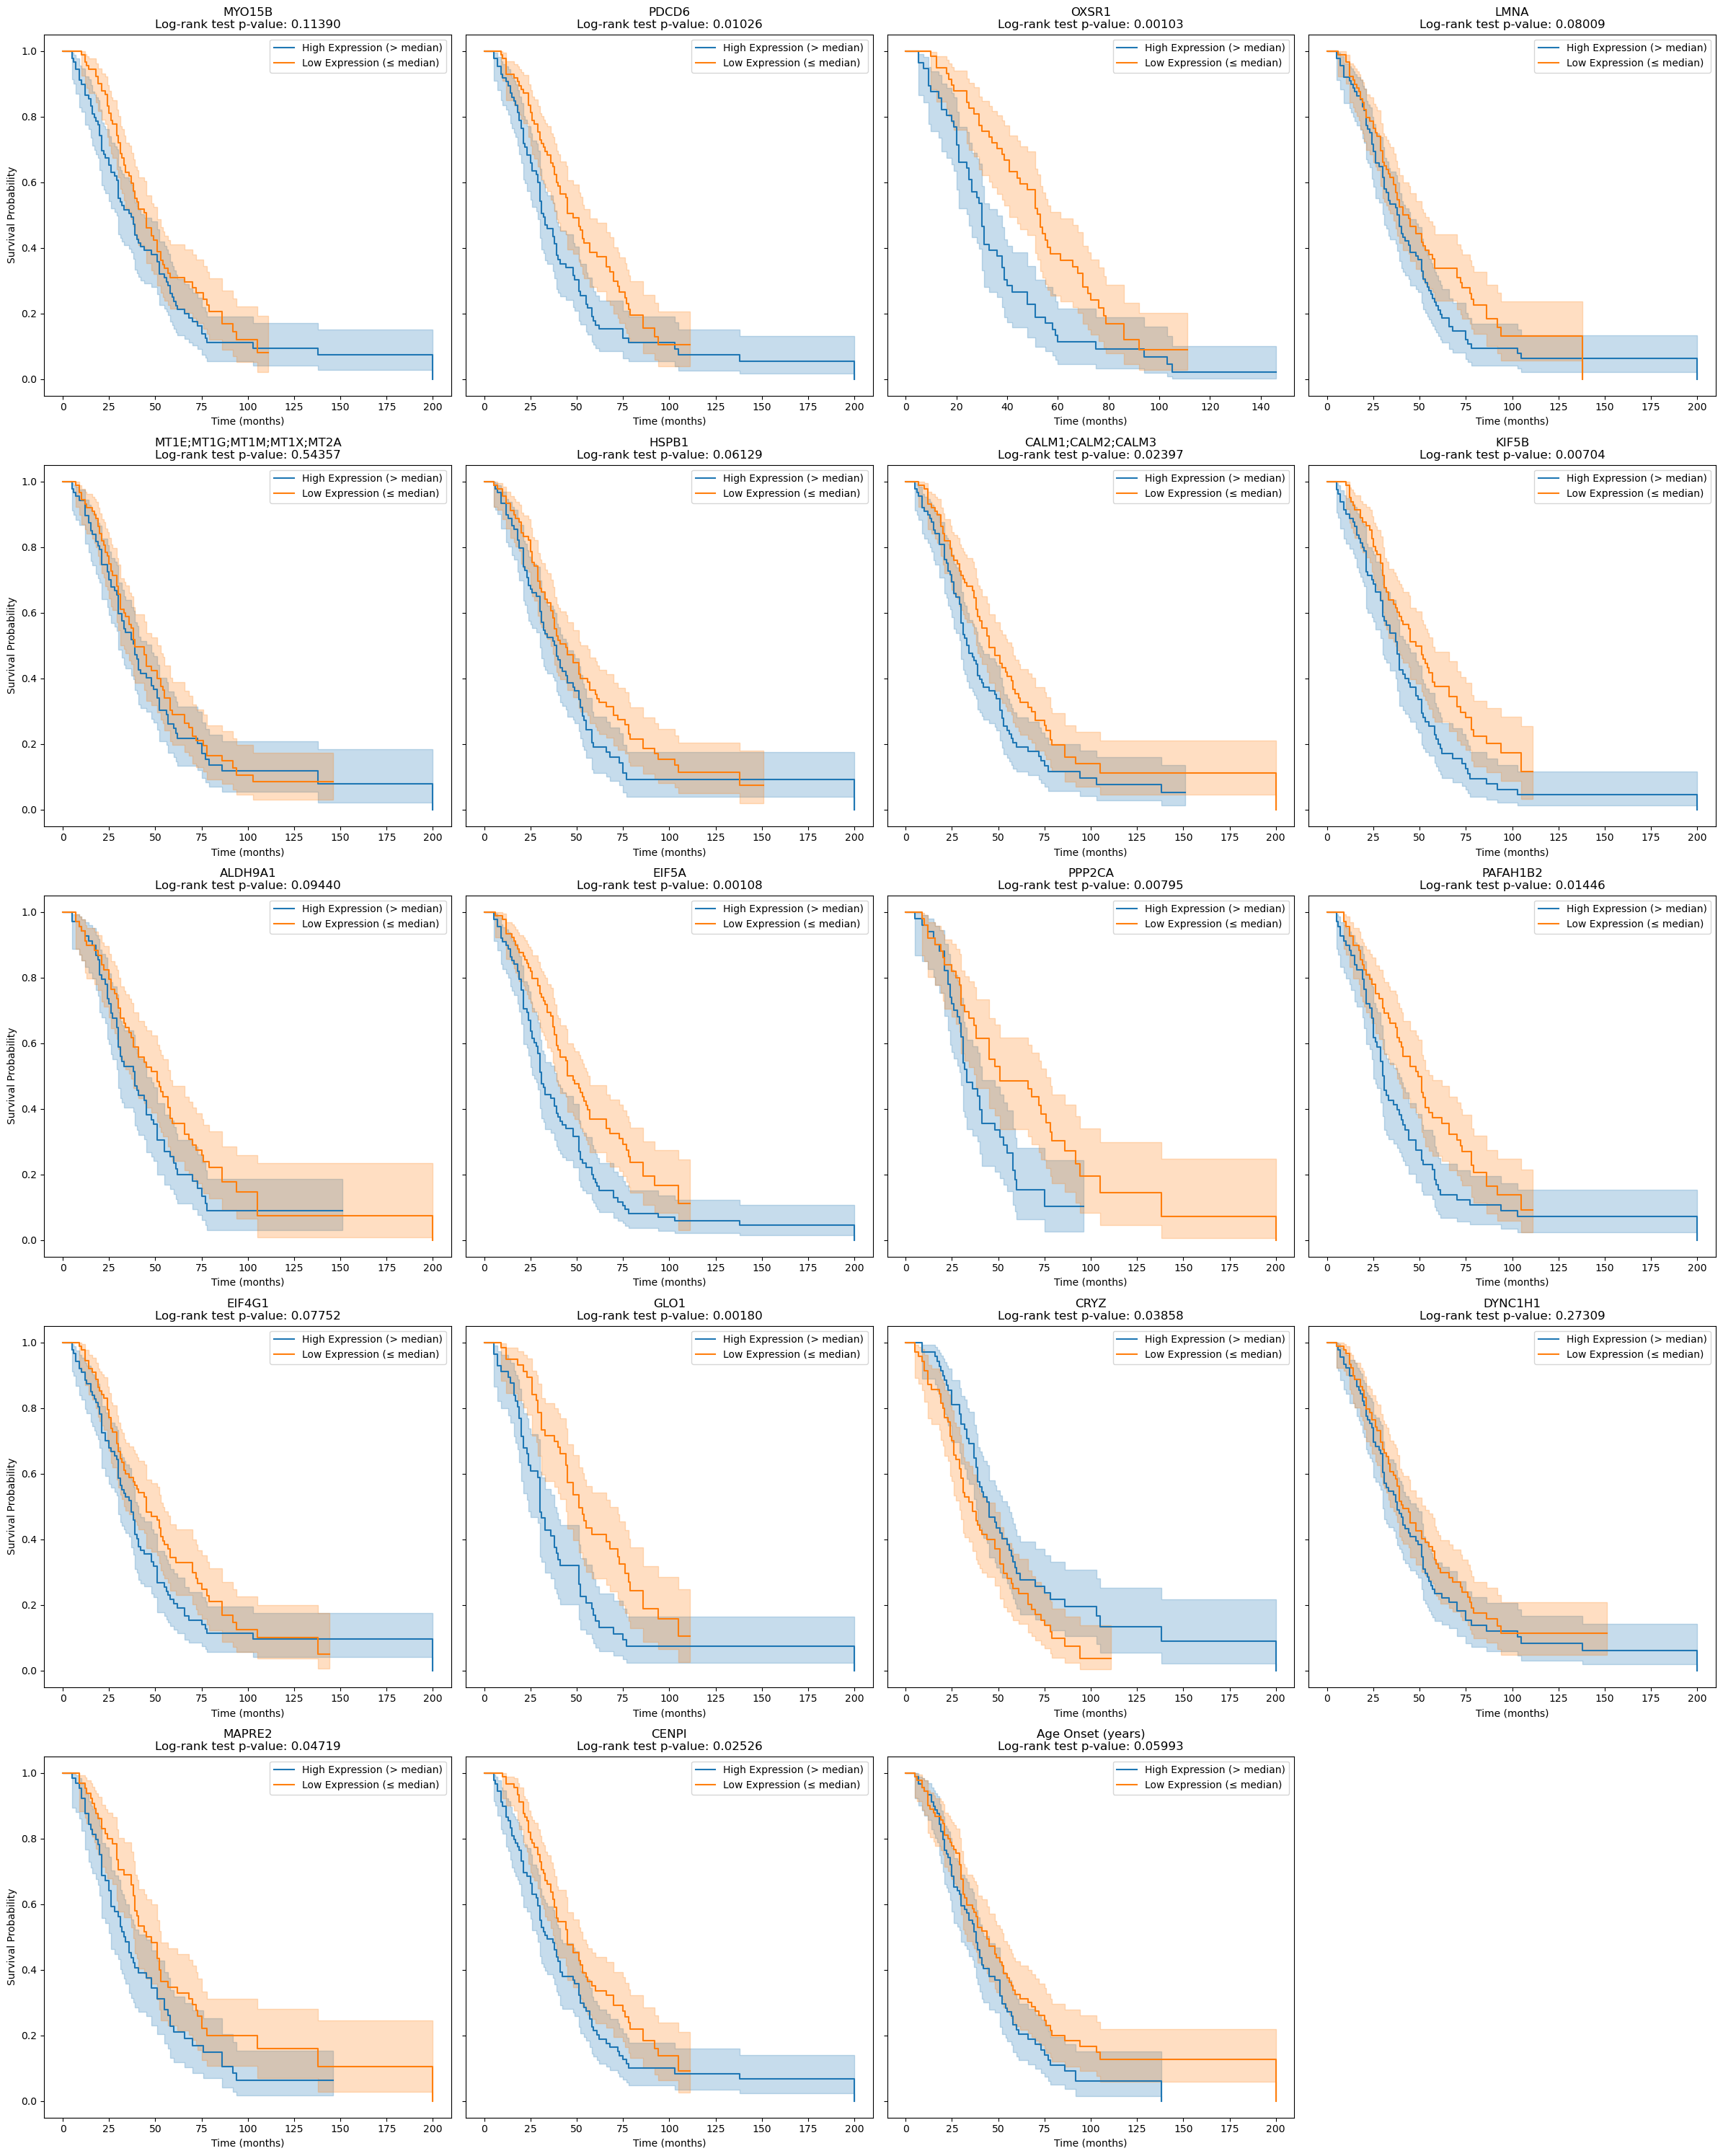

In [41]:

kmf = KaplanMeierFitter()
num_proteins = len(MIN_FEATURES)
num_cols = 4
num_rows = (num_proteins + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 6, num_rows * 6), sharey=True)
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, protein in enumerate(MIN_FEATURES):
    ax = axes[i]
    
    # Create high and low expression groups based on the median
    median_threshold = data[protein].median()
    
    # Only consider the high and low groups
    high_group = data[data[protein] > median_threshold]
    low_group = data[data[protein] <= median_threshold]
    
    # Calculate the log-rank test p-value
    result = statistics.logrank_test(high_group['Survival_from_onset (months)'], 
                                     low_group['Survival_from_onset (months)'], 
                                     event_observed_A=high_group['Status dead=1'], 
                                     event_observed_B=low_group['Status dead=1'])
    p_value = result.p_value
    
    # Plot high expression group
    kmf.fit(durations=high_group['Survival_from_onset (months)'], 
            event_observed=high_group['Status dead=1'], 
            label='High Expression (> median)')
    kmf.plot_survival_function(ax=ax)
    
    # Plot low expression group
    kmf.fit(durations=low_group['Survival_from_onset (months)'], 
            event_observed=low_group['Status dead=1'], 
            label='Low Expression (≤ median)')
    kmf.plot_survival_function(ax=ax)
    
    ax.set_title(f'{protein}\nLog-rank test p-value: {p_value:.5f}')
    ax.set_xlabel('Time (months)')
    if i % num_cols == 0:
        ax.set_ylabel('Survival Probability')
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


##### km seperation base on quantile

In [ ]:
import numpy as np
import pandas as pd
from lifelines import KaplanMeierFitter, statistics
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

for protein in PROTEIN_FOR_KM:
    plt.figure(figsize=(8, 6))
    
    # Create high and low expression groups based on the 25th and 75th percentiles
    q25_threshold = data[protein].quantile(0.25)
    q75_threshold = data[protein].quantile(0.75)
    
    # Only consider the high and low groups
    high_group = data[data[protein] > q75_threshold]
    low_group = data[data[protein] <= q25_threshold]
    
    # Calculate the log-rank test p-value
    result = statistics.logrank_test(high_group['Survival_from_onset (months)'], 
                                     low_group['Survival_from_onset (months)'], 
                                     event_observed_A=high_group['Status dead=1'], 
                                     event_observed_B=low_group['Status dead=1'])
    p_value = result.p_value
    print(f'Log-rank test p-value for {protein}: {p_value}')
    
    # Plot high expression group
    kmf.fit(durations=high_group['Survival_from_onset (months)'], 
            event_observed=high_group['Status dead=1'], 
            label='High Expression (> 75th percentile)')
    kmf.plot_survival_function()
    
    # Plot low expression group
    kmf.fit(durations=low_group['Survival_from_onset (months)'], 
            event_observed=low_group['Status dead=1'], 
            label='Low Expression (≤ 25th percentile)')
    kmf.plot_survival_function()
    
    plt.title(f'Kaplan-Meier Survival Curve for {protein}')
    plt.xlabel('Time (months)')
    plt.ylabel('Survival Probability')
    plt.legend()
    plt.show()


## imputate data for cox analysis

In [ ]:

# Assuming 'data' is your DataFrame and 'MIN_FEATURES' is your list of columns
# Filter the data to include only the relevant columns for imputation
data_filtered = data[MIN_FEATURES]

# Impute missing values using KNN with specified parameters
imputer = KNNImputer(n_neighbors=3, weights='uniform', metric='nan_euclidean')
data_imputed = imputer.fit_transform(data_filtered)

# Create a DataFrame with the imputed data
data_imputed_df = pd.DataFrame(data_imputed, columns=MIN_FEATURES)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_imputed_df[MIN_FEATURES[:-2]])  # exclude 'Status dead=1' and 'Survival_from_onset (months)'

# Create a new DataFrame with the scaled features
scaled_data = pd.DataFrame(scaled_features, columns=MIN_FEATURES[:-2])
scaled_data['Status dead=1'] = data_imputed_df['Status dead=1']
scaled_data['Survival_from_onset (months)'] = data_imputed_df['Survival_from_onset (months)']

# Initialize and fit the Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(scaled_data, duration_col='Survival_from_onset (months)', event_col='Status dead=1')

# Print the summary of the Cox model
print(cph.summary)

# Collect the original p-values
original_p_values = cph.summary['p'].to_dict()

# Initialize dictionaries to store permutation results
permuted_p_values = {feature: [] for feature in MIN_FEATURES[:-2]}

# Perform 100 permutations
for i in range(100):
    shuffled_data = scaled_data.copy()
    shuffled_data['Status dead=1'] = np.random.permutation(shuffled_data['Status dead=1'])
    
    # Fit the Cox model on the shuffled data
    cph.fit(shuffled_data, duration_col='Survival_from_onset (months)', event_col='Status dead=1')
    
    # Store the p-values for this permutation
    for feature in MIN_FEATURES[:-2]:
        permuted_p_values[feature].append(cph.summary.loc[feature, 'p'])

# Compare original p-values to permutation distribution
permutation_results = {}
for feature in MIN_FEATURES[:-2]:
    permuted_distribution = np.array(permuted_p_values[feature])
    original_p_value = original_p_values[feature]
    permuted_p = (np.sum(permuted_distribution <= original_p_value) + 1) / (100 + 1)  # Adding 1 for the observed p-value
    
    permutation_results[feature] = permuted_p

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'original_p_value': pd.Series(original_p_values),
    'permuted_p_value': pd.Series(permutation_results),
    'concordance_index': cph.concordance_index_,
    'hazard_ratio': pd.Series(cph.hazard_ratios_.to_dict())
})

# Display the DataFrame
print(results_df)


In [ ]:

# Filter the data to include only the relevant columns for imputation
data_filtered = data[MIN_FEATURES]

# Impute missing values using KNN with specified parameters
imputer = KNNImputer(n_neighbors=3, weights='uniform', metric='nan_euclidean')
data_imputed = imputer.fit_transform(data_filtered)

# Create a DataFrame with the imputed data
data_imputed_df = pd.DataFrame(data_imputed, columns=MIN_FEATURES)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_imputed_df[MIN_FEATURES[:-2]])  # exclude 'Status dead=1' and 'Survival_from_onset (months)'

# Create a new DataFrame with the scaled features
scaled_data = pd.DataFrame(scaled_features, columns=MIN_FEATURES[:-2])
scaled_data['Status dead=1'] = data_imputed_df['Status dead=1']
scaled_data['Survival_from_onset (months)'] = data_imputed_df['Survival_from_onset (months)']

# # Drop rows with missing values in the survival columns
# cox_data = scaled_data.dropna(subset=['Status dead=1', 'Survival_from_onset (months)'])

# Initialize and fit the Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(scaled_data, duration_col='Survival_from_onset (months)', event_col='Status dead=1')

# Print the summary of the Cox model
print(cph.summary)

# Collect the results into a DataFrame
cox_p = cph.summary['p'].to_dict()
concordance_index = cph.concordance_index_
hazard_ratios = cph.hazard_ratios_.to_dict()

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'p_value': pd.Series(cox_p),
    'concordance_index': concordance_index,
    'hazard_ratio': pd.Series(hazard_ratios)
})

# Display the DataFrame
print(results_df)



In [7]:
# Filter significant proteins
significant_cox = results_df[results_df['original_p_value'] < 0.05]
significant_cox

,original_p_value,permuted_p_value,concordance_index,hazard_ratio
ACTN3,0.000001,0.158416,0.70453,0.667288
SHH,0.001096,0.009901,0.70453,1.297154


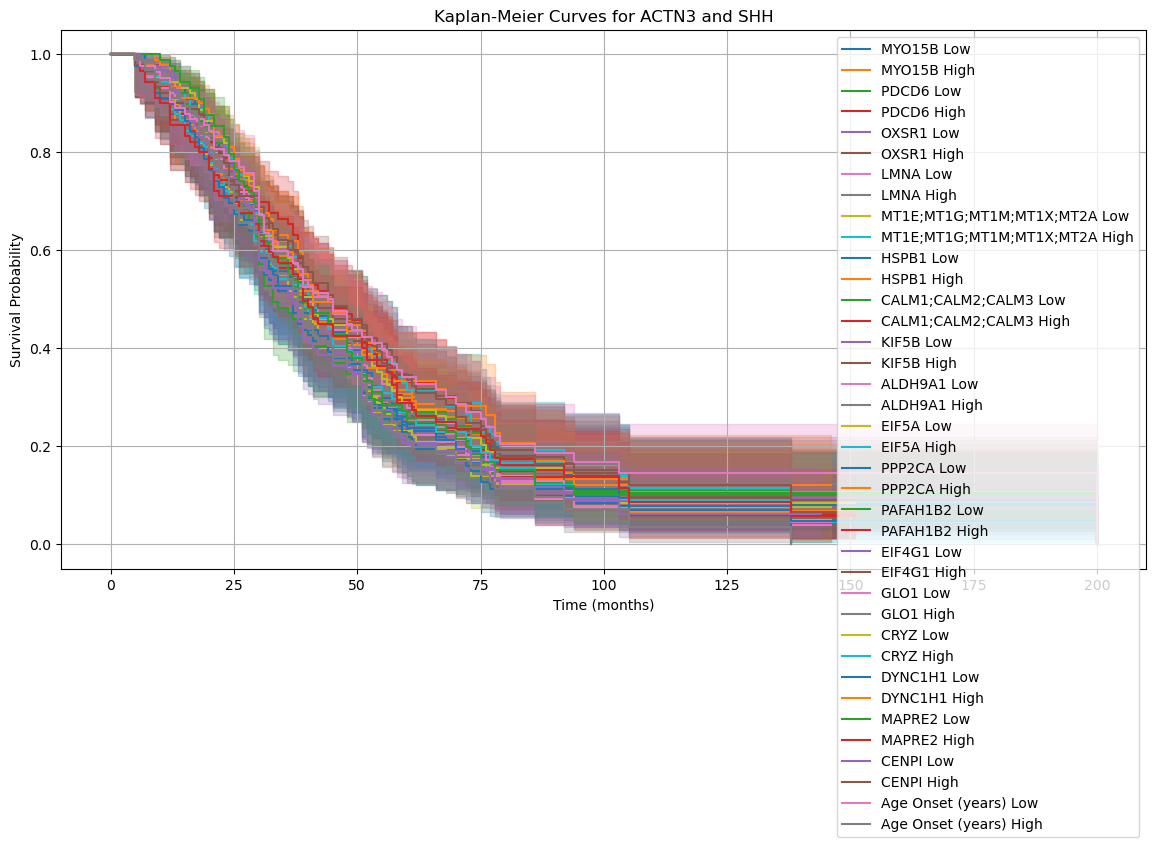

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Load your dataset (assuming it is already loaded in the variable `data`)
# data = pd.read_csv('your_data.csv')  # Uncomment this line if you need to load the data

# Define the proteins of interest
proteins = MIN_FEATURES

# Ensure the dataset contains the necessary columns
assert all(protein in data.columns for protein in proteins), "Dataset must contain the specified proteins."

# Define the survival columns
survival_time_col = 'Survival_from_onset (months)'
event_col = 'Status dead=1'

# Create a binary indicator for high and low expression levels
def create_binary_indicator(df, protein, threshold=None):
    if threshold is None:
        threshold = df[protein].median()
    return df[protein] >= threshold

# Initialize KaplanMeierFitter
kmf = KaplanMeierFitter()

# Plot KM curves for each protein
plt.figure(figsize=(14, 7))

for protein in proteins:
    data[f'{protein}_high'] = create_binary_indicator(data, protein)
    
    for label, group in data.groupby(f'{protein}_high'):
        kmf.fit(group[survival_time_col], event_observed=group[event_col], label=f'{protein} {"High" if label else "Low"}')
        kmf.plot_survival_function()

plt.title('Kaplan-Meier Curves for ACTN3 and SHH')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# Define the proteins of interest
proteins = MIN_FEATURES

# Ensure the dataset contains the necessary columns
assert all(protein in data.columns for protein in proteins), "Dataset must contain the specified proteins."

# Define the survival columns
survival_time_col = 'Survival_from_onset (months)'
event_col = 'Status dead=1'

# Create a binary indicator for high and low expression levels
def create_binary_indicator(df, protein, threshold=None):
    if threshold is None:
        threshold = df[protein].median()
    return df[protein] >= threshold

# Initialize KaplanMeierFitter
kmf = KaplanMeierFitter()

# Plot KM curves for each protein in separate plots
for protein in proteins:
    plt.figure(figsize=(10, 7))
    
    data[f'{protein}_high'] = create_binary_indicator(data, protein)
    
    for label, group in data.groupby(f'{protein}_high'):
        kmf.fit(group[survival_time_col], event_observed=group[event_col], label=f'{protein} {"High" if label else "Low"}')
        kmf.plot_survival_function()
    
    plt.title(f'Kaplan-Meier Curve for {protein}')
    plt.xlabel('Time (months)')
    plt.ylabel('Survival Probability')
    plt.legend()
    plt.grid(True)
    plt.show()


In [48]:
data

,MYO15B,PDCD6,OXSR1,LMNA,MT1E;MT1G;MT1M;MT1X;MT2A,HSPB1,CALM1;CALM2;CALM3,KIF5B,ALDH9A1,EIF5A,PPP2CA,PAFAH1B2,EIF4G1,GLO1,CRYZ,DYNC1H1,MAPRE2,CENPI,Age Onset (years)
sample number,,,,,,,,,,,,,,,,,,,
705,-10.691947,-11.000069,-31.303171,-10.155609,-10.225090,-10.767508,-10.889207,-31.303171,-10.966463,-10.783098,-10.712842,-10.475755,-10.350165,-31.303171,-11.092131,-31.303171,-31.303171,-11.026459,73
712,-10.800141,-31.362377,-31.362377,-10.224005,-10.329907,-10.832190,-10.801467,-31.362377,-10.970464,-10.882890,-10.774521,-10.546868,-10.458835,-31.362377,-11.158459,-31.362377,-31.362377,-11.184733,63
717,-10.694556,-10.939834,-31.285681,-10.096219,-10.214266,-10.701171,-10.855088,-31.285681,-10.927299,-31.285681,-10.794503,-10.403282,-10.332540,-31.285681,-11.088936,-31.285681,-31.285681,-11.084296,70
735,-10.701350,-31.306051,-31.306051,-10.178585,-10.239107,-10.743080,-10.872423,-31.306051,-31.306051,-10.930930,-10.735678,-10.499109,-10.361036,-31.306051,-11.075863,-31.306051,-31.306051,-11.098615,65
746,-10.811340,-11.185034,-31.383629,-10.208688,-10.347055,-10.930287,-11.008729,-31.383629,-10.942633,-10.931521,-10.736683,-10.602710,-10.474707,-31.383629,-31.383629,-31.383629,-11.236995,-11.068958,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,-10.468262,-10.918506,-31.244110,-10.081963,-10.148311,-10.855366,-10.882241,-31.244110,-10.962994,-31.244110,-10.882220,-10.418203,-10.265753,-31.244110,-31.244110,-31.244110,-31.244110,-11.132959,64
1900,-10.501466,-10.660884,-31.237343,-10.076883,-10.132538,-10.749960,-10.846355,-31.237343,-10.815759,-31.237343,-10.771743,-10.434360,-10.262714,-31.237343,-10.833950,-31.237343,-31.237343,-11.070303,78
1912,-10.596728,-10.736551,-31.290314,-10.163491,-10.208292,-10.907243,-10.788104,-31.290314,-10.852730,-10.849492,-10.696483,-10.495294,-10.319266,-10.995449,-31.290314,-10.698153,-31.290314,-31.290314,55


In [ ]:

data = data[COX_LIST]

# cox multivariant 

### COX UNIVARIANT WITH CROSS VALIDATION

In [60]:


data = data[COX_LIST]

cox_p = {}
concordance_index = {}
hazard_ratios = {}

protein_names = [col for col in data.columns if col not in ['Status dead=1', 'Survival_from_onset (months)']]

# Initialize KFold
kf = KFold(n_splits=10, shuffle=True, random_state=1)

for protein_name in protein_names:
    p_values = []
    c_indices = []
    hazard_ratios_fold = []

    for train_index, test_index in kf.split(data):
        train_data = data.iloc[train_index].dropna(subset=[protein_name])
        test_data = data.iloc[test_index].dropna(subset=[protein_name])
        
        if train_data.empty or test_data.empty:
            continue

        cph = CoxPHFitter()
        cph.fit(train_data[[protein_name, 'Status dead=1', 'Survival_from_onset (months)']],
                duration_col='Survival_from_onset (months)', event_col='Status dead=1')

        p_value = cph.summary.loc[protein_name]['p']
        c_index = cph.concordance_index_
        hazard_ratio = cph.hazard_ratios_[protein_name]

        p_values.append(p_value)
        c_indices.append(c_index)
        hazard_ratios_fold.append(hazard_ratio)

    # Store the average results of cross-validation
    cox_p[protein_name] = sum(p_values) / len(p_values) if p_values else None
    concordance_index[protein_name] = sum(c_indices) / len(c_indices) if c_indices else None
    hazard_ratios[protein_name] = sum(hazard_ratios_fold) / len(hazard_ratios_fold) if hazard_ratios_fold else None
# Create a DataFrame with the results
results_df = pd.DataFrame({
    'p_value': pd.Series(cox_p),
    'concordance_index': pd.Series(concordance_index),
    'hazard_ratio': pd.Series(hazard_ratios)
})

# Display the DataFrame
print(results_df)

                           p_value  concordance_index  hazard_ratio
MYO15B                    0.318516           0.517454      0.499470
PDCD6                     0.009087           0.551472      0.960228
OXSR1                     0.370063           0.498612      1.022213
LMNA                      0.719828           0.499467      0.847438
MT1E;MT1G;MT1M;MT1X;MT2A  0.582460           0.510357      0.671710
HSPB1                     0.409847           0.498000      0.984030
CALM1;CALM2;CALM3         0.420998           0.519278      0.545160
KIF5B                     0.288142           0.517479      0.980283
ALDH9A1                   0.297723           0.520678      0.985682
EIF5A                     0.147077           0.531947      0.987323
PPP2CA                    0.504453           0.479243      1.018430
PAFAH1B2                  0.672139           0.506224      0.758127
EIF4G1                    0.458153           0.507472      0.558671
GLO1                      0.190844           0.5

### COX univariant WITHOUT cross validation

In [58]:


# Assuming final_df is your dataset
data = data[COX_LIST]

cox_p = {}
concordance_index = {}
hazard_ratios = {}

protein_names = [col for col in data.columns if col not in ['Status dead=1', 'Survival_from_onset (months)']]

for protein_name in protein_names:
    
    
    # Fit the Cox Proportional Hazards model
    cph = CoxPHFitter()
    cph.fit(cox_data[[protein_name, 'Status dead=1', 'Survival_from_onset (months)']],
            duration_col='Survival_from_onset (months)', event_col='Status dead=1')

    # Extract p-value, concordance index, and hazard ratio
    p_value = cph.summary.loc[protein_name]['p']
    c_index = cph.concordance_index_
    hazard_ratio = cph.hazard_ratios_[protein_name]

    # Store results
    cox_p[protein_name] = p_value
    concordance_index[protein_name] = c_index
    hazard_ratios[protein_name] = hazard_ratio

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'p_value': pd.Series(cox_p),
    'concordance_index': pd.Series(concordance_index),
    'hazard_ratio': pd.Series(hazard_ratios)
})

# Display the DataFrame
print(results_df)


                           p_value  concordance_index  hazard_ratio
MYO15B                    0.252185           0.517679      0.478253
PDCD6                     0.004731           0.551205      0.960199
OXSR1                     0.335250           0.498337      1.022273
LMNA                      0.766999           0.488836      0.797936
MT1E;MT1G;MT1M;MT1X;MT2A  0.546115           0.506413      0.634449
HSPB1                     0.373748           0.497998      0.984257
CALM1;CALM2;CALM3         0.365755           0.519240      0.520731
KIF5B                     0.238892           0.517543      0.980193
ALDH9A1                   0.248117           0.520665      0.985801
EIF5A                     0.114634           0.531999      0.987395
PPP2CA                    0.485992           0.475331      1.017335
PAFAH1B2                  0.660286           0.502816      0.735097
EIF4G1                    0.398503           0.507567      0.529864
GLO1                      0.139029           0.5